In [1]:
import numpy as np
import torch as tr
import torch.nn as nn
from torch import distributions
from torch.nn.parameter import Parameter
import phi4_mg as m
import phi4 as p
import integrators as i
import update as u

import time
import matplotlib.pyplot as plt
from tqdm import tqdm

import argparse
import sys

import time
from stacked_model import *

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
os.environ["PATH"] = "/sciclone/home/yacahuanamedra/texlive/bin/x86_64-linux:" + os.environ["PATH"]

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amsfonts}')
import pickle


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

In [3]:
!pwd

/sciclone/pscr/yacahuanamedra/torchNJL


torch.Size([2, 2048, 2048])


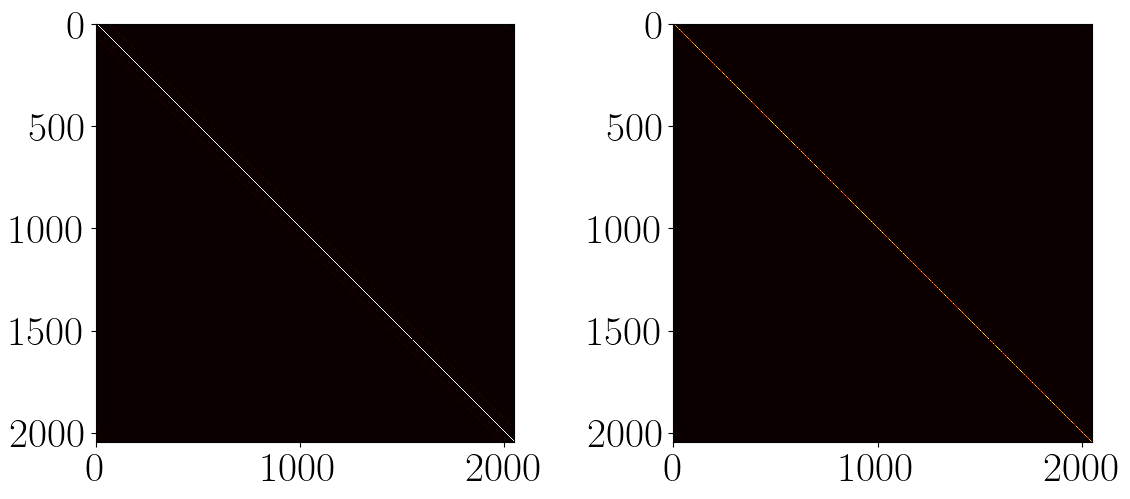

In [4]:
import njl as psi
L = 32
model = psi.njl(V=(L,L), l=0.2, m=0.1,Nf=2,batch_size=2)
sig=model.hotStart()
D_W = model.build_DW_wilson(sig)
sig1=model.coldStart()
D_W1 = model.build_DW_wilson(sig1)

# Verifica dimensiones
print(D_W.shape)  # torch.Size([32, 32]) para L=4
#print imshow
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[1].imshow(D_W[1].abs().numpy(), cmap='hot', interpolation='nearest')
ax[0].imshow(D_W1[1].abs().numpy(), cmap='hot', interpolation='nearest')



torch.Size([2048]) torch.Size([2048])


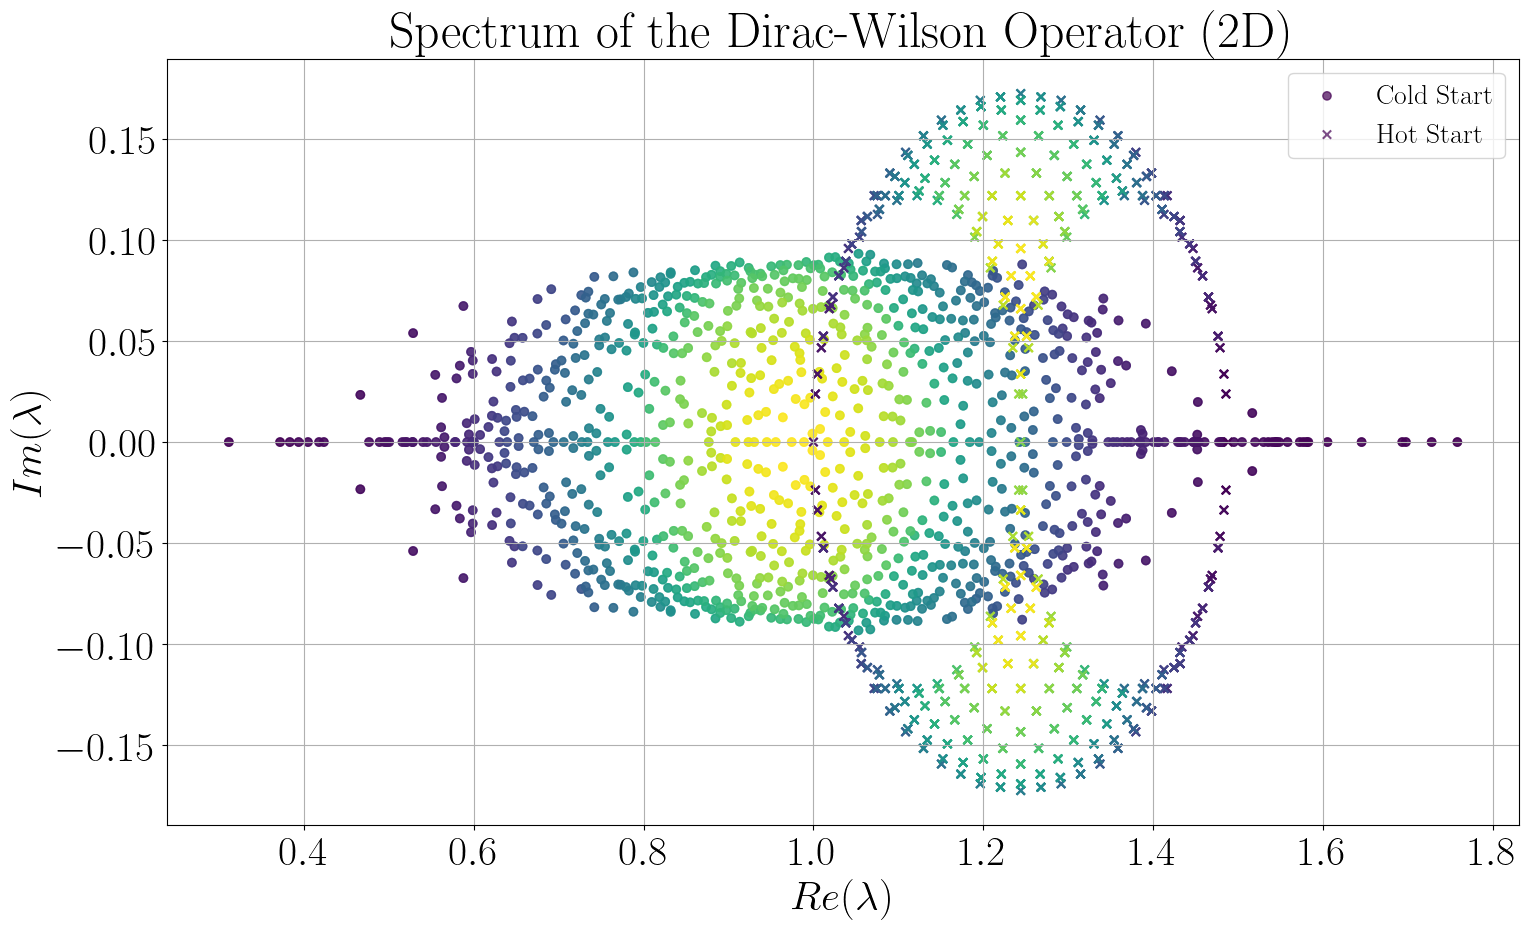

In [5]:
eigvals = tr.linalg.eigvals(D_W[0])
eigenvals1 = tr.linalg.eigvals(D_W1[0])
print(eigvals.real.shape, eigvals.imag.shape)
eigvals_np = eigvals.detach().cpu().numpy()
eigenvals1_np = eigenvals1 .detach().cpu().numpy()

plt.figure(figsize=(16, 10))
#points random colors
colors = plt.cm.viridis(np.linspace(0, 1, eigvals_np.shape[0]))
#random colors
#colors = np.random.rand(eigvals_np.shape[0], 3)
plt.scatter(eigvals_np.real, eigvals_np.imag,alpha=0.7, marker='o',color=colors,label='Cold Start')
plt.scatter(eigenvals1_np.real, eigenvals1_np.imag,alpha=0.7, marker='x',color=colors,label='Hot Start')
plt.legend(fontsize=20)
plt.xlabel(r"$Re(\lambda)$")
plt.ylabel(r"$Im(\lambda)$")
eigen_number = D_W.shape[0]
plt.title(f"Spectrum of the Dirac-Wilson Operator (2D)")
#plt.xlim(0.4, 1.6)

plt.grid(True)
#plt.gca().set_aspect('equal')
plt.show()

# Derivative of the fermion action

In [7]:
V = L * L
phi = model.pseudofermion_field(D_W)
Ddag = D_W.transpose(-2, -1).conj()
Q = tr.matmul(Ddag, D_W)
x = tr.linalg.solve(Q, phi.unsqueeze(-1))  # x = (D†D)^(-1) phi

force = tr.zeros_like(sig, dtype=model.dtype)
for x_pos in range(L):
    for y_pos in range(L):
        site = model.site_index(x_pos, y_pos, L)
        for a in range(2):
            idx = 2 * site + a
            # grad_Sf = 2 * Re[ x†(x) * phi(x) ]
            f = 2.0 * tr.real(tr.conj(x[:, idx, 0]) * x[:, idx, 0])
            force[:, x_pos, y_pos] += f

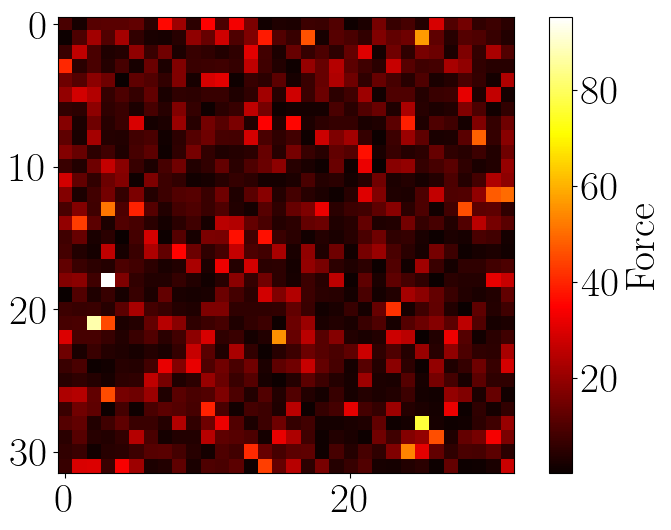

In [11]:
#plot force magnitude
plt.figure(figsize=(8, 6))
plt.imshow(force[0].numpy(), cmap='hot')
plt.colorbar(label='Force')


## HMC